In [1]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"

import jax_sbgeom as jsb
%load_ext autoreload
%autoreload 2
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import numpy as onp
import sys 
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import StellBlanket.SBGeom as SBGeom
from functools import partial
import jax_sbgeom.coils as jsc

from tests.coils.test_coils import _check_single_vectorized_internal
import pyvista as pv
from dataclasses import dataclass


vmec_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/helias3_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/helias5_vmec.nc4", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_vmec.nc4"]
vmec_file = vmec_files[1]

coil_files = ["/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS3_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/HELIAS5_coils_all.h5", "/home/tbogaarts/stellarator_paper/base_data/vmecs/squid_coilset.h5"]

Triangle Elements not compiled


In [2]:
def _get_discrete_coils(coil_file, coil_index=0):
    sbgeom_coils = SBGeom.Coils.Discrete_Coil_Set_From_HDF5(coil_file)
    print(sbgeom_coils.Number_of_Coils())
    coil_0 = sbgeom_coils[coil_index]
    coil_0_jsc = jsc.DiscreteCoil.from_positions(coil_0.Get_Vertices())
    return coil_0_jsc, coil_0

c_jax, c_sbgeom = _get_discrete_coils(coil_files[1])

50


In [3]:
class TestQ:
    param : str
    def __init__(self, param):
        self.param = param

def _get_all_discrete_coils(request):    
    coilset_sbgeom = SBGeom.Coils.Discrete_Coil_Set_From_HDF5(request.param)    
    coilset_jaxsbgeom = jsb.coils.CoilSet([jsb.coils.DiscreteCoil.from_positions(coilset_sbgeom[i].Get_Vertices()) for i in range(coilset_sbgeom.Number_of_Coils())])
    
    return coilset_jaxsbgeom, coilset_sbgeom

TestQ(coil_files[1])

jsb_coils, sbcoils = _get_all_discrete_coils(TestQ(coil_files[1]))

In [4]:
coil = sbcoils[0]
ns = 2000


In [5]:
ns = 3000
s_new = jnp.linspace(0.0, 1.0, ns, endpoint=False)

In [25]:
ns = 7000
s_new = jnp.linspace(0.0, 1.0, ns, endpoint=False)
centroid_0 = coil.Finite_Size_Lines_Centroid(0.3, 0.5, ns) 
centroid_frame = jsc.discrete_coil._discrete_coil_finite_size_frame_centroid(jsb_coils[0].positions, jsb_coils[0].centre(), s_new)
centroid_1 = jsc.base_coil._finite_size(jsb_coils[0], s_new, 0.5, 0.3, centroid_frame)
centroid_2 = jnp.moveaxis(centroid_1, 1,0).reshape(-1,3)

jnp.allclose(centroid_0, centroid_2, atol=1e-7)

Array(True, dtype=bool)

11.8769058   9.88469687 -2.94359914]

In [22]:
print(jnp.isclose(centroid_0, centroid_2, atol=1e-7))

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [ True  True

In [7]:
n_verts = jsb_coils[0].positions.shape[0]

In [8]:
print(sbcoils[0].Tangent(28 /  (n_verts) ))
print(sbcoils[0].Tangent(29 /  (n_verts ) + 1e-10))

[-0.97454579  0.06494227 -0.21457636]
[-0.97212571  0.01338892 -0.23407762]


In [9]:
mesh_sbg = sbcoils[0].Mesh_Triangles_Centroid(0.3,0.5, ns)


connectivity_sbg = mesh_sbg.connectivity




In [10]:
import pyvista as pv
sbmesh = mesh_sbg.to_pyvista()
jmesh = SBGeom.Mesh.Mesh(onp.array(centroid_1).reshape(-1,3), connectivity_sbg).to_pyvista()

plotter= pv.Plotter(shape = (1,2))

plotter.subplot(0,0)
plotter.add_mesh(sbmesh)
plotter.add_mesh(jmesh, color = 'red' )
plotter.subplot(0,1)


plotter.show()

Widget(value='<iframe src="http://localhost:43521/index.html?ui=P_0x7958747a0b30_0&reconnect=auto" class="pyvi…

In [11]:
def _sampling_s(n_s : int = 1000):
    return jnp.linspace(0.0, 1.0, n_s)



jsc.base_coil._finite_size_frame_centroid(jsb_coils[0], 0.2)


Array([[ 0.27447318,  0.1055702 ,  0.95578209],
       [ 0.16229381,  0.97461059, -0.15425601]], dtype=float64)

In [12]:
_check_single_vectorized_internal(c_jax.position)

In [13]:
forward_tangent = jnp.vectorize(jax.jacfwd(jsc.discrete_coil._discrete_coil_position, argnums = (1)), excluded = (0,),  signature='()->(3)')

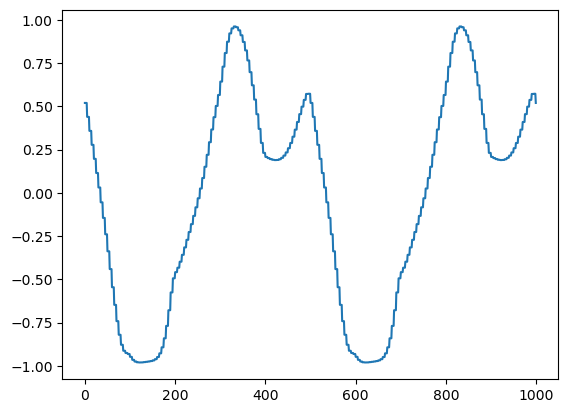

In [14]:
def print_tan(s):
    tan = c_jax.tangent(s)
    tan2 =  tan / jnp.linalg.norm(tan, axis=-1, keepdims=True)
    return tan2

import matplotlib.pyplot as plt
plt.plot(print_tan(jnp.linspace(0.0, 2.0, 1000))[:,0])

In [15]:
finite_diff_tangent = (c_sbgeom.Position(0.2 + 1e-5) - c_sbgeom.Position(0.2 - 1e-5)) / (2e-5)
print(finite_diff_tangent / onp.linalg.norm(finite_diff_tangent))

[-0.94061089  0.17715166  0.28960048]


In [16]:
c_sbgeom.Tangent(1.0)

array([ 0.51905794, -0.73056176,  0.44368725])

In [17]:
c_jax.position(0.2)

Array([18.62909802, 14.03445065,  2.9819    ], dtype=float64)

In [18]:
jsc.DiscreteCoil()

TypeError: DiscreteCoil.__init__() missing 2 required positional arguments: 'positions' and '_centre_i'